In [1]:
# This code is used to overlap simulated light curve and 
# Kepler Lightcurve

In [2]:
# Import TF and check for GPU

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Import required libraries

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import save_model, load_model
import math
import sys


2023-10-03 21:18:48.071693: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-03 21:18:48.946799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/abraham/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.1


# Load kepler light curves

In [3]:
filenames = ['../data/tfr_shallue/tfr_all/tfrecord/train-00000-of-00008',
             '../data/tfr_shallue/tfr_all/tfrecord/train-00001-of-00008',
             '../data/tfr_shallue/tfr_all/tfrecord/train-00002-of-00008',
             '../data/tfr_shallue/tfr_all/tfrecord/train-00003-of-00008',
             '../data/tfr_shallue/tfr_all/tfrecord/train-00004-of-00008',
             '../data/tfr_shallue/tfr_all/tfrecord/train-00005-of-00008',
             '../data/tfr_shallue/tfr_all/tfrecord/train-00006-of-00008',
             '../data/tfr_shallue/tfr_all/tfrecord/train-00007-of-00008',
             '../data/tfr_shallue/tfr_all/tfrecord/val-00000-of-00001',
             '../data/tfr_shallue/tfr_all/tfrecord/test-00000-of-00001']
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

feature_description = {
    'global_view': tf.io.FixedLenSequenceFeature([], tf.float32, default_value=0.0,allow_missing=True),
    'local_view': tf.io.FixedLenSequenceFeature([], tf.float32, default_value=0.0,allow_missing=True),
    'av_training_set': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'kepid': tf.io.FixedLenSequenceFeature([], tf.int64, default_value=int(0),allow_missing=True),
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

# At this point the dataset contains serialized tf.train.Example messages.
# When iterated over it returns these as scalar string tensors.
# Use the .take method to only show the first 10 records.
for raw_record in raw_dataset.take(10):
  print(repr(raw_record))
  
parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset


# Calculate the size of one light curve corresponding to 'local_view'
y = np.array([])
for elem in parsed_dataset.take(1):
  y = np.append(y,[elem['local_view']])
length_lc = len(y)
print("length_lc = " ,length_lc)


# Calculate total number of light curves
no_data = 0
for elem in parsed_dataset.as_numpy_iterator():
    no_data = no_data + 1
print('no_data = ',no_data)

# Extract Kepler ID
kepid_array = np.zeros(shape=(no_data,))
i = 0
for elem in parsed_dataset:
    kepid_array[i] = elem['kepid'] 
    i = i + 1

# convert all tf dataset to np array (light curve numpy array (lc_np_array))
lc_np_array = np.zeros(shape=(no_data,length_lc))
lc_np_array.shape

i = 0
for elem in parsed_dataset.as_numpy_iterator():
    lc_np_array[i] = elem['local_view'] #+1.0
    i = i + 1

print('lc_np_array[0] = ',lc_np_array[0])


2023-10-03 21:18:51.059463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30931 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-10-03 21:18:52.136269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]
2023-10-03 21:18:52.202494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]


<tf.Tensor: shape=(), dtype=string, numpy=b'\n\xdbG\n\x15\n\x0ctce_plnt_num\x12\x05\x1a\x03\n\x01\x02\n\x19\n\x0fav_training_set\x12\x06\n\x04\n\x02PC\n\x1b\n\x0ftce_max_mult_ev\x12\x08\x12\x06\n\x04H\xe1\x06B\n\x1a\n\x0espline_bkspace\x12\x08\x12\x06\n\x04\x9a\xa97@\n\x17\n\rav_pred_class\x12\x06\n\x04\n\x02PC\n\x15\n\ttce_depth\x12\x08\x12\x06\n\x043\x13PD\n\x16\n\ntce_impact\x12\x08\x12\x06\n\x04\x94\xf66?\n\x19\n\rtce_model_snr\x12\x08\x12\x06\n\x04\x14\xae\x02B\n\x14\n\x08tce_prad\x12\x08\x12\x06\n\x04\xecQ@@\n\x17\n\x0btce_time0bk\x12\x08\x12\x06\n\x04\x17\x193C\n\xda>\n\x0bglobal_view\x12\xca>\x12\xc7>\n\xc4>\x8a\x99\xbc<\xde\x8f\x9c\xbdl\xf5l<(s\r=o\x1f\xe8\xba\t\xcf\xbd\xbcG\n\xc2\xbc"\x1f\x17\xbc\xfd&\xd1\xbc\x15w*=f\xa1v\xbc\xea\x95\xf0\xbci\xcb\xf1<\x00\x00\x00\x00g6t\xbd\x1f\xf5\x9b=\xabg\x87<]\xc5\x1d=.\xc7\x83<\\0\xa0\xbd\xb0&\x00>\x98\xd6\xa6<\x96A)\xbcb\x84\x96\xbd\xb6)\xaa\xbd)\x08\x8b\xbc\x1c\x1cm>\xab\x16\xbb=}\\R=\xf3\x13b\xbc\x02\xe6\xc9\xbdg6t\xbd\x93\x17\xae\xbc

2023-10-03 21:18:52.235513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]


no_data =  15737
lc_np_array[0] =  [-6.92397356e-02 -2.56392676e-02 -4.75080535e-02 -6.34126291e-02
 -2.86556520e-02 -7.22561181e-02 -7.22561181e-02  1.56303551e-02
  3.60595062e-02  5.99163622e-02  5.51175699e-02 -4.38746847e-02
  6.16987748e-03  4.48344424e-02  2.11146921e-02  1.93322822e-02
  4.11325163e-04 -4.53828759e-02 -5.10728732e-02 -5.02502210e-02
 -3.57852876e-02 -9.18626133e-03  3.29060107e-02  5.47062457e-02
 -7.54096126e-03  1.37108378e-04  2.26228833e-02  2.57763769e-02
  1.12977311e-01  9.85809267e-02  7.41756335e-02  3.29060107e-02
 -7.87687674e-02  2.42681839e-02  1.53561393e-02  8.08939431e-03
 -1.70014389e-02 -8.80235806e-02 -7.41756335e-02 -7.97970816e-02
 -5.81339560e-02 -2.64619179e-02 -3.08493860e-02  2.33084261e-02
 -3.53739634e-02 -3.53739634e-02  1.37108390e-03  1.09686712e-02
 -1.68643314e-02  1.72756556e-02  1.87838487e-02  1.87838487e-02
  2.60505918e-03  6.95139542e-02 -4.53828759e-02 -6.64975643e-02
  6.71831099e-03 -4.66168523e-02 -2.87927613e-02 -5.539

7115530


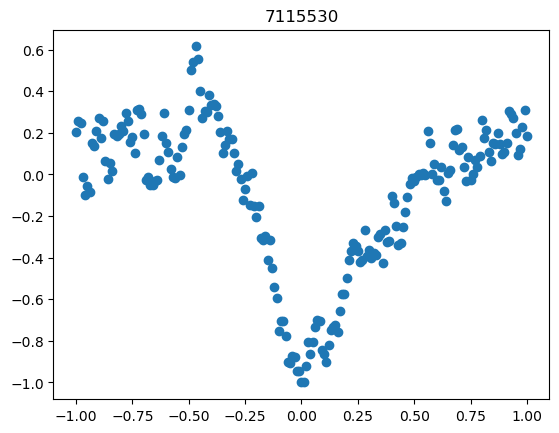

In [6]:
for i in np.arange(1):
    j=981
    test_lc = lc_np_array[j]
    ph = np.linspace(-1.0,1.0,len(lc_np_array[0]))
    plt.scatter(ph, test_lc)
    print(int(kepid_array[j]))
    plt.title(f"{int(kepid_array[j])}")
    plt.show()

# Load simulation light curves